##Imorting modules

The aim of this project is to perform a comparative analysis of feature extarction of CNN ans SWIN Transformer models and use different ML classifiers for classification to find the best performed model

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization,Dropout
from tensorflow.keras.models import Sequential
!pip install -q -U keras-tuner
from tensorflow import keras
from tensorflow.keras import regularizers
from kerastuner import RandomSearch
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from Utilis_function import window_partitioning
from Utilis_function import Drop_path
from Utilis_function import Swin_Transformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.9 MB/s eta 0:00:00


<ipython-input-1-c5cb56dc4687>:25: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [ ]:
from google.colab import drive
drive.mount('/content/drive' , force_remount=True)

Mounted at /content/drive


In [ ]:
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/ChestXRayNeP/chest_xray/train')
data_dir1 =pathlib.Path('/content/drive/MyDrive/ChestXRayNeP/chest_xray/test')


In [ ]:
#Defining image size
image_H = 224
image_W = 224
IMG_SIZE = (image_H,image_W)
BATCH_SIZE = 32
#defining the variables for swin transformer model

num_classes = 1
in_size = (224,224,3)
batch_size = 64
pt_size = (4,4)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 4  # Size of attention window


x_patchnumber = in_size[0] // pt_size[0]
y_patchnumber = in_size[1] // pt_size[1]

lr = 1e-2
decay_wt = 0.001
smooth_lb = 0.1
import numpy as np


###Defining functions for class counting ,plotting and data augmentation

In [ ]:
def class_count(data,name):
  class_counts = {"NORMAL": 0, "PNEUMONIA": 0}
  for images, labels in data:
      for label in labels.numpy():
          if label == 0:
              class_counts["NORMAL"] += 1
          elif label == 1:
              class_counts["PNEUMONIA"] += 1
  print(f"Number of NORMAL images in {name} is ",class_counts["NORMAL"])
  print(f"Number of PNEUMONIA images in {name} is ",class_counts["PNEUMONIA"])
  return class_counts["NORMAL"],class_counts["PNEUMONIA"]

In [ ]:
def confusion_m(prediction,test_labels,color):
  cm = confusion_matrix(test_labels, prediction)
  sns.set(rc={'font.family': 'serif', 'font.size': 18})
  labels = list(['NORMAL','PNEUMONIA'])
  plt.figure(figsize=(5, 5))
  sns.heatmap(cm, annot=True, fmt='d', cmap=color, linewidths=.5, linecolor='black' , xticklabels=class_labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()


In [ ]:
#Defining function to plot images by iterating throught the batches
def plot_images(data):
  batch = next(iter(data))
  images, labels = batch
  class_names = {0: "NORMAL", 1: "PNEUMONIA"}
  plt.figure(figsize=(20,8))
  plt.suptitle("Images in Training Dataset", fontsize=16)
  for i in range(min(5, len(images))):
      plt.subplot(2, 5, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i].numpy()])
      plt.axis('off')

  plt.show()


In [ ]:
#Defining the function for plotting the class distribution
def plot_class_counts(normal, pneumonia,name):
  classes = ['NORMAL', 'PNEUMONIA']
  counts = [normal, pneumonia]
  plt.bar(classes, counts,  color=['#9BF6FB', '#F3FD91'])
  plt.xlabel('Class')
  plt.title(f'Class Counts in the {name}')
  plt.show()

In [ ]:
#Defining the data augmentation function
def img_process_train(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)



    image = tf.cast(image, 'float32')/255.
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image, label

def img_process_test(image, label):

    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, 'float32')/255.
    return image, label


##Loading Datasets

In [ ]:
#Loading the dataset from google drive with 80% Training data and 20% validation Data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=2,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=2,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
#Loading the test dataset

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir1,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


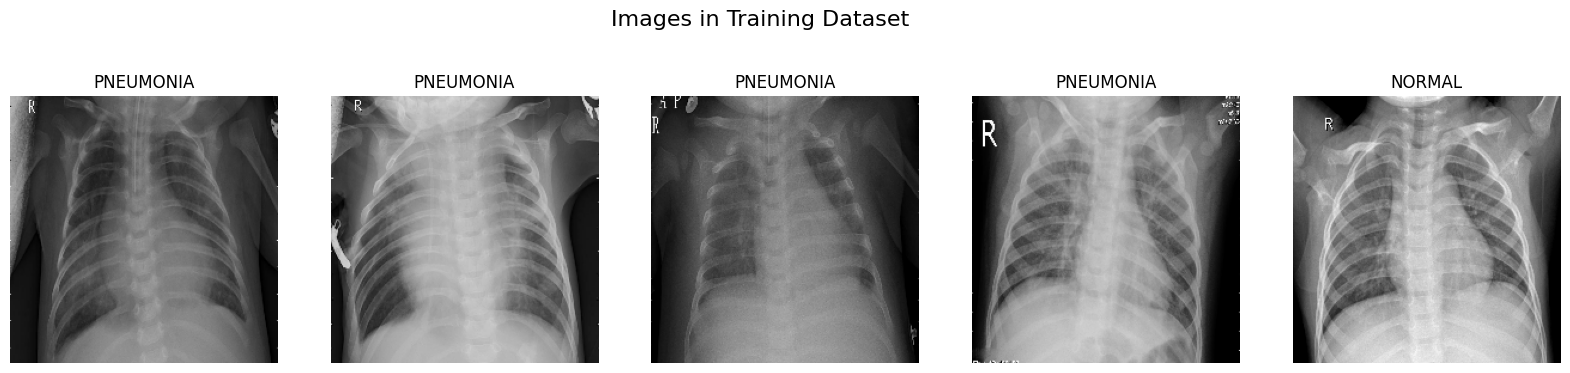

In [ ]:
# Plotting Training Images
plot_images(train_ds)

In [ ]:
#Counting the images belonging to NORMAL and PNEUMONIA classes
X,Y=class_count(train_ds,name="training")
P,Q=class_count(valid_ds,name="validation")


Number of NORMAL images in training is  1078
Number of PNEUMONIA images in training is  3108
Number of NORMAL images in validation is  271
Number of PNEUMONIA images in validation is  775


In [ ]:
F,G=class_count(test_ds,name="test")

Number of NORMAL images in test is  234
Number of PNEUMONIA images in test is  390


##PREPROCESSING


In [ ]:
#Seperating the normal and pneumonia data in training  and validation dataset as class imbalance observed and balancing image counts
train_normal_ds = train_ds.unbatch().filter(lambda x, y:  tf.equal(y, 0) ).batch(32)
train_pneumonia_ds=train_ds.unbatch().filter(lambda x, y:  tf.equal(y, 1) ).take(1600).batch(32)
valid_normal_ds = valid_ds.unbatch().filter(lambda x, y:  tf.equal(y, 0) ).batch(32)
valid_pneumonia_ds=valid_ds.unbatch().filter(lambda x, y:  tf.equal(y, 1) ).take(300).batch(32)

In [ ]:
#Forming the balaced Tarin dataset
tra_n =train_normal_ds.unbatch()
train_p =train_pneumonia_ds.unbatch()
train_ds_raw=tra_n.concatenate(train_p)
Train = train_ds_raw.shuffle(buffer_size=3000, seed=42)
Train_data = Train.batch(32)

In [ ]:
#Forming the balance validation dataset
val_n =valid_normal_ds.unbatch()
val_p =valid_pneumonia_ds.unbatch()
valid_ds_raw=val_n.concatenate(val_p)
Valid = valid_ds_raw.shuffle(buffer_size=500, seed=42)
Valid_data = Valid.batch(32)

In [ ]:
U,V=class_count(Train_data,name="training")

Number of NORMAL images in training is  1078
Number of PNEUMONIA images in training is  1600


###Applying Image Augmentation

In [ ]:
Train_ds_augmented = Train_data.map(img_process_train)
Valid_ds = Valid_data.map(img_process_test)
test_ds=test_ds.map(img_process_test)


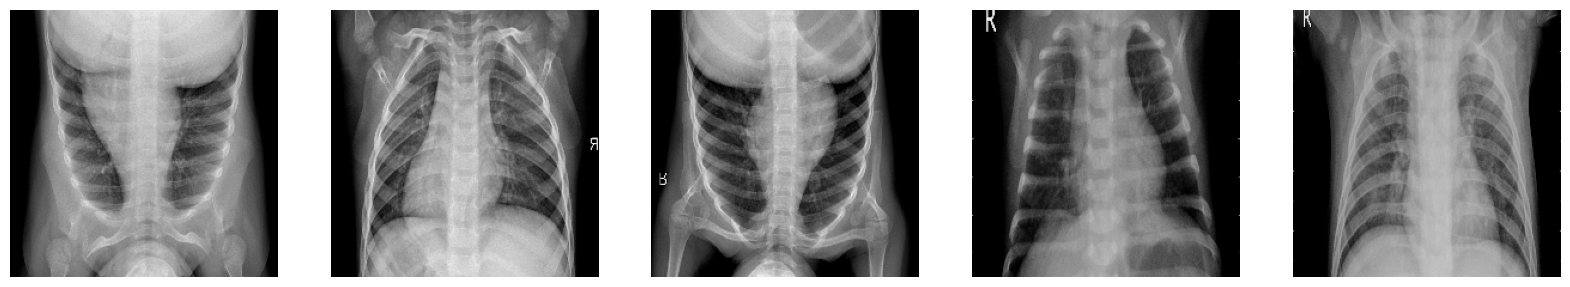

In [ ]:
#Displaying the augmented image arrays
batch = next(iter(Train_ds_augmented))
plt.figure(figsize=(20, 8))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(batch[0][i].numpy())
    plt.axis('off')

plt.show()

In [ ]:
#Applying prefetch and autotune for computational efficiency
Train_Data_11 = Train_ds_augmented.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
Valid_Data = Valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
Train_Data_1 = Train_Data_11.take(1000)
Valid_Data_1 = Valid_Data.take(200)

####Plotting the Data Distribution

In [ ]:
N,P = class_count(Train_ds_augmented,name ="augmented trainind dataset")


Number of NORMAL images in augmented trainind dataset is  1078
Number of PNEUMONIA images in augmented trainind dataset is  1600


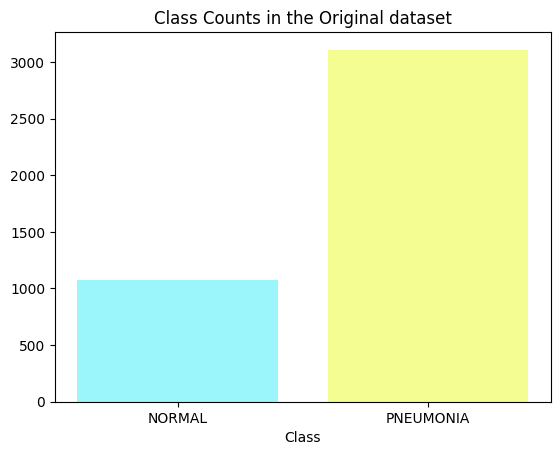

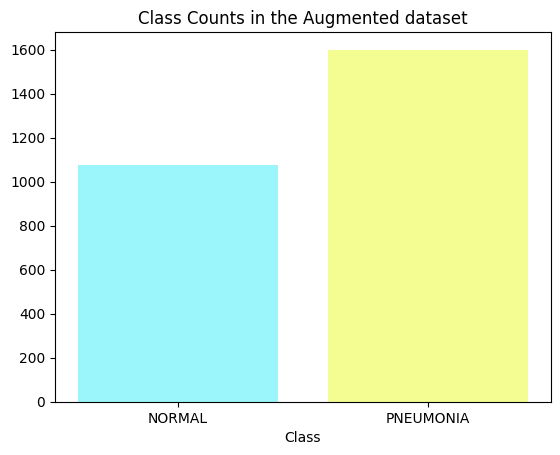

In [ ]:
plot_class_counts(X,Y,name="Original dataset")
plot_class_counts(N,P,name = "Augmented dataset")

##CNN MODEL

##HYperparameter Tuning

In [ ]:
#utilizing keras tuner function to estimate the best set of hyperparameters
def Hypermodel(kt) :
    model=keras.models.Sequential()
    model.add(Input(shape=(224,224,3)))
    for i in range(kt.Int('number_of_conv2d_layers',1,5)):
        model.add(Conv2D(filters=kt.Choice(f'{i}_conv2d_filters',values=[16,32,64]),kernel_size=kt.Choice(f'{i}_kernel_choice',values=[3,5,7]),activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(kt.Choice(name='dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(units=1,activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(kt.Choice('learning_rate', values=[1e-2, 1e-3,1e-5])),
                  loss='binary_crossentropy'
                  ,metrics='accuracy')
    return model

In [ ]:
tuner=RandomSearch(Hypermodel,objective='val_accuracy',max_trials=3,executions_per_trial=1,directory='CNN',project_name='Hyper_tuninig')

Reloading Tuner from CNN/Hyper_tuninig/tuner0.json


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 14
number_of_conv2d_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
0_conv2d_filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
0_kernel_choice (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
dropout0 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 1e-05], 'ordered': True}
1_conv2d_filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
1_kernel_choice (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
dropout1 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'ordered': True}
2_conv2d_filters (Choice)
{'default': 16, 'conditions': [], 'v

In [ ]:
tuner.search(Train_Data_1,validation_data=Valid_Data_1,epochs=1,batch_size=1)

In [ ]:
tuner.results_summary()

In [ ]:
model=tuner.get_best_models(num_models=1)[0]

In [ ]:
#prininting the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [ ]:
history_opt = model.fit(Train_Data_1,
                    validation_data=Valid_Data_1,
                    epochs=20,
                    #class_weight=class_weight
                    shuffle=True
                    )

Epoch 1/20
84/84 [==============================] - 36s 136ms/step - loss: 0.4738 - binary_accuracy: 0.8476 - val_loss: 1.3726 - val_binary_accuracy: 0.5254
Epoch 2/20
84/84 [==============================] - 5s 58ms/step - loss: 0.3301 - binary_accuracy: 0.9197 - val_loss: 1.4696 - val_binary_accuracy: 0.5254
Epoch 3/20
84/84 [==============================] - 5s 58ms/step - loss: 0.3168 - binary_accuracy: 0.9216 - val_loss: 1.7431 - val_binary_accuracy: 0.5254
Epoch 4/20
84/84 [==============================] - 5s 58ms/step - loss: 0.2608 - binary_accuracy: 0.9455 - val_loss: 1.9918 - val_binary_accuracy: 0.5254
Epoch 5/20
84/84 [==============================] - 5s 58ms/step - loss: 0.2518 - binary_accuracy: 0.9462 - val_loss: 1.9304 - val_binary_accuracy: 0.5254
Epoch 6/20
84/84 [==============================] - 5s 58ms/step - loss: 0.2390 - binary_accuracy: 0.9541 - val_loss: 1.6171 - val_binary_accuracy: 0.5271
Epoch 7/20
84/84 [==============================] - 5s 58ms/step - l

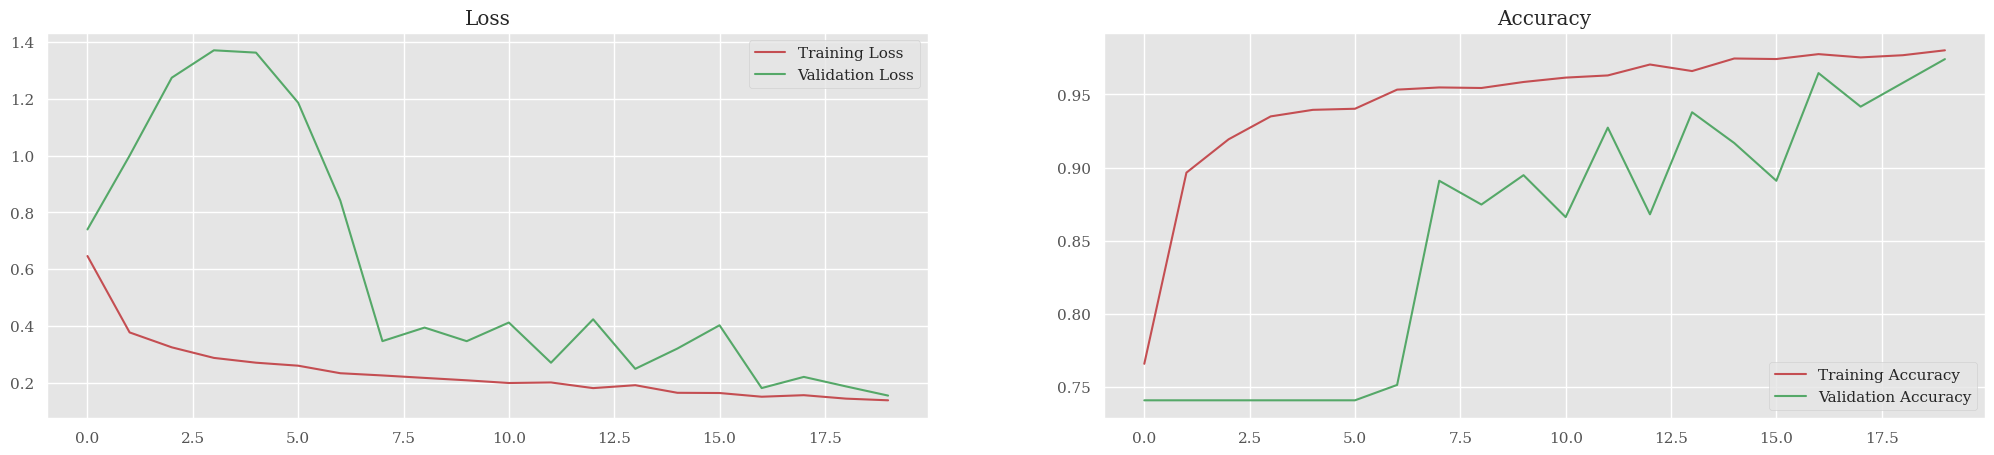

In [ ]:
#Plotting the accuracy and model loss for CNN
def show_final_history(history):

    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(25,5))

    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')

    ax[0].plot(history.history['loss'], "r-", label='Training Loss')
    ax[0].plot(history.history['val_loss'], "g-", label='Validation Loss')
    ax[1].plot(history.history['binary_accuracy'], "r-", label='Training Accuracy')
    ax[1].plot(history.history['val_binary_accuracy'], "g-", label='Validation Accuracy')

    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')

    plt.show();

    pass
show_final_history(history_opt)

In [ ]:
#Evaluating the validation
score = model.evaluate(Valid_Data)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

18/18 [==============================] - 0s 16ms/step - loss: 0.2081 - binary_accuracy: 0.9632
Val loss: 0.20809516310691833
Val accuracy: 0.9632224440574646


In [ ]:
#Evaluating test data
score = model.evaluate(test_ds)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

20/20 [==============================] - 1s 65ms/step - loss: 1.1359 - binary_accuracy: 0.7628
Test loss: 1.1359161138534546
Test accuracy: 0.7628205418586731


##SWIN MODEL

In [ ]:
in_lay = layers.Input(in_size)
x = EXt_Patch(pt_size)(in_lay)
x = Emb_patch(x_patchnumber * y_patchnumber, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(x_patchnumber, y_patchnumber),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(x_patchnumber, y_patchnumber),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=1,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
out1 = Mer_Patch((x_patchnumber, y_patchnumber), embed_dim=embed_dim)(x)
out2 = layers.GlobalAveragePooling1D()(out1)
S_out = layers.Dense(1, activation="softmax")(out2)

In [ ]:
swin_model1 = keras.Model(in_lay, S_out)
swin_model1.compile(
    loss=keras.losses.BinaryCrossentropy(label_smoothing=smooth_lb),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=lr, weight_decay=decay_wt
    ),
    metrics=['accuracy']

)

In [ ]:
swin_model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 e_xt__patch (EXt_Patch)     (None, 3136, 48)          0         
                                                                 
 emb_patch (Emb_patch)       (None, 3136, 64)          203840    
                                                                 
 swin_transformer (SwinTran  (None, 3136, 64)          50632     
 sformer)                                                        
                                                                 
 swin_transformer_1 (SwinTr  (None, 3136, 64)          100808    
 ansformer)                                                      
                                                                 
 mer__patch (Mer_Patch)      (None, 784, 128)          32768 

In [ ]:
history = swin_model1.fit(
    Train_Data_11,
    batch_size = batch_size,
    epochs = 10,
    validation_data = Valid_Data,
)

Epoch 1/10
84/84 [==============================] - 35s 350ms/step - loss: 2.3200 - accuracy: 0.5975 - val_loss: 0.6865 - val_accuracy: 0.5254
Epoch 2/10
84/84 [==============================] - 28s 338ms/step - loss: 0.6759 - accuracy: 0.5975 - val_loss: 0.6958 - val_accuracy: 0.5254
Epoch 3/10
84/84 [==============================] - 28s 334ms/step - loss: 0.6736 - accuracy: 0.5975 - val_loss: 0.6894 - val_accuracy: 0.5254
Epoch 4/10
84/84 [==============================] - 28s 337ms/step - loss: 0.6512 - accuracy: 0.5975 - val_loss: 0.7080 - val_accuracy: 0.5254
Epoch 5/10
84/84 [==============================] - 28s 337ms/step - loss: 0.6580 - accuracy: 0.5975 - val_loss: 0.7270 - val_accuracy: 0.5254
Epoch 6/10
84/84 [==============================] - 28s 336ms/step - loss: 0.6431 - accuracy: 0.5975 - val_loss: 0.6422 - val_accuracy: 0.5254
Epoch 7/10
84/84 [==============================] - 28s 337ms/step - loss: 0.6860 - accuracy: 0.5975 - val_loss: 0.6795 - val_accuracy: 0.5254

##Feature Extraction

In [ ]:
from tensorflow.keras.models import Model


layer_name = 'flatten'
feature_extractor_model_CNN = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)


CNN_features = feature_extractor_model_CNN.predict(Train_Data_1)
CNN_features1 = feature_extractor_model_CNN.predict(test_ds)

20/20 [==============================] - 1s 52ms/step


In [ ]:
layer_name = 'global_average_pooling1d'
feature_extractor_model_swin = Model(inputs=swin_model1.input, outputs=swin_model1.get_layer(layer_name).output)


Swin_features = feature_extractor_model_swin.predict(Train_Data_1)
Swin_features1 = feature_extractor_model_swin.predict(test_ds)

20/20 [==============================] - 2s 97ms/step


In [ ]:
#printing the number of train and test data
test_labels = []
train_labels = []
for _, labels in Train_Data_1:
    for label in labels:
        train_labels.append(label.numpy())
print(len(train_labels))
for image, label in test_ds:
  for i in label:
    test_labels.append(label[i].numpy())
print(len(test_labels))
train_labels = np.array(train_labels)


2678
624


##ML CLASSIFIERS

##SoftMax Classifier

In [ ]:
def Softmax_classification(train_features,extracted_feature):
  softmax_classifier = LogisticRegression(max_iter=1000)
  softmax_classifier.fit(train_features, train_labels)
  S_predictions = softmax_classifier.predict(extracted_feature)

  S_accuracy = accuracy_score(test_labels, S_predictions)
  print("Accuracy:", S_accuracy)
  print(classification_report(test_labels, S_predictions))
  return S_predictions

##SVM

In [ ]:
def SVM_classification(train_features,extracted_feature):
  svm_classifier = svm.SVC(kernel='rbf')
  svm_classifier.fit(train_features,train_labels)
  SVM_predictions = svm_classifier.predict(extracted_feature)

  # Calculate accuracy
  SVM_accuracy = accuracy_score(test_labels, SVM_predictions)
  print("SVM Accuracy:", SVM_accuracy)
  print(classification_report(test_labels, SVM_predictions))
  return SVM_predictions

##Random Forest

In [ ]:
def Random_forest_classification(train_features,extracted_feature):
  rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
  rf_classifier.fit(train_features, train_labels)
  RF_predictions = rf_classifier.predict(extracted_feature)
  RF_accuracy = accuracy_score(test_labels, RF_predictions)
  print(f"Random Forest Accuracy: {RF_accuracy:.2f}")
  print(classification_report(test_labels, RF_predictions))
  return RF_predictions

##KNN Classifier

In [ ]:
def KNN_classification(train_features,extracted_feature):
  knn_classifier = KNeighborsClassifier(n_neighbors=8)
  knn_classifier.fit(train_features, train_labels)
  KNN_y_pred = knn_classifier.predict(extracted_feature)
  KNN_accuracy = accuracy_score(test_labels, KNN_y_pred)
  print(f"kNN Accuracy: {KNN_accuracy:.2f}")
  print(classification_report(test_labels, KNN_y_pred))
  return KNN_y_pred

##Adaptive Boosting

In [ ]:
def adaboost_classifier(train_features,extracted_feature):
  weak_learner = DecisionTreeClassifier(max_depth=1)
  adaboost_classifier = AdaBoostClassifier(base_estimator=weak_learner, n_estimators=50)
  adaboost_classifier.fit(train_features, train_labels)
  y_pred_adaboost = adaboost_classifier.predict(extracted_feature)
  ada_accuracy = accuracy_score(test_labels, y_pred_adaboost)
  print(f"Accuracy: {ada_accuracy:.2f}")
  print(classification_report(test_labels, y_pred_adaboost))
  return y_pred_adaboost



###Displaying classification reports for CNN

In [ ]:
Softmax_predictions = Softmax_classification(CNN_features,CNN_features1)
SVM_predictions=SVM_classification(CNN_features,CNN_features1)
RF_predictions = Random_forest_classification(CNN_features,CNN_features1)
KNN_predictions =KNN_classification(CNN_features,CNN_features1)
adaboost_predictions = adaboost_classifier(CNN_features,CNN_features1)

Accuracy: 0.7307692307692307
              precision    recall  f1-score   support

           0       0.92      0.38      0.54       256
           1       0.69      0.98      0.81       368

    accuracy                           0.73       624
   macro avg       0.80      0.68      0.67       624
weighted avg       0.78      0.73      0.70       624

SVM Accuracy: 0.7628205128205128
              precision    recall  f1-score   support

           0       0.88      0.49      0.63       256
           1       0.73      0.95      0.83       368

    accuracy                           0.76       624
   macro avg       0.80      0.72      0.73       624
weighted avg       0.79      0.76      0.75       624

Random Forest Accuracy: 0.82
              precision    recall  f1-score   support

           0       0.88      0.66      0.75       256
           1       0.80      0.93      0.86       368

    accuracy                           0.82       624
   macro avg       0.84      0.80    

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.90      0.52      0.66       256
           1       0.74      0.96      0.84       368

    accuracy                           0.78       624
   macro avg       0.82      0.74      0.75       624
weighted avg       0.81      0.78      0.76       624



###Classification Reports for SWIN Tansformer


In [ ]:
Swin_Softmax_predictions = Softmax_classification(Swin_features,Swin_features1)
Swin_SVM_predictions=SVM_classification(Swin_features,Swin_features1)
Swin_RF_predictions = Random_forest_classification(Swin_features,Swin_features1)
Swin_KNN_predictions =KNN_classification(Swin_features,Swin_features1)
Swin_adaboost_predictions = adaboost_classifier(Swin_features,Swin_features1)

Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       256
           1       0.76      0.84      0.80       368

    accuracy                           0.75       624
   macro avg       0.74      0.73      0.74       624
weighted avg       0.75      0.75      0.75       624

SVM Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.75      0.59      0.66       256
           1       0.75      0.86      0.80       368

    accuracy                           0.75       624
   macro avg       0.75      0.73      0.73       624
weighted avg       0.75      0.75      0.74       624

Random Forest Accuracy: 0.74
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       256
           1       0.76      0.82      0.79       368

    accuracy                           0.74       624
   macro avg       0.73      0.72      0.73       624
weighted av

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.72      0.63      0.67       256
           1       0.76      0.83      0.80       368

    accuracy                           0.75       624
   macro avg       0.74      0.73      0.73       624
weighted avg       0.75      0.75      0.75       624



##Plotting the confusion matrices

###CNN and its classifiers

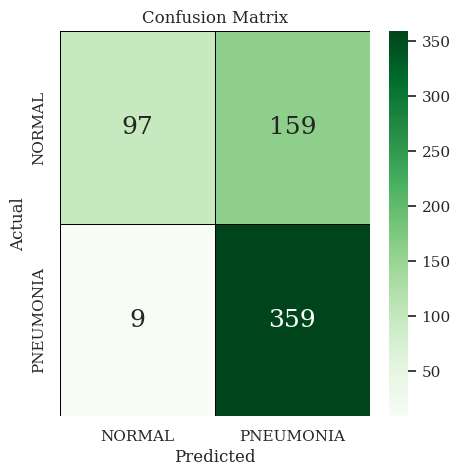

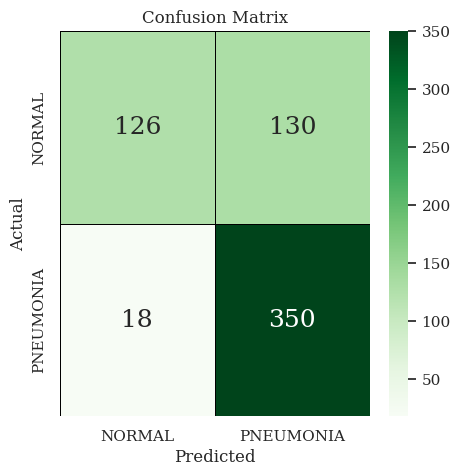

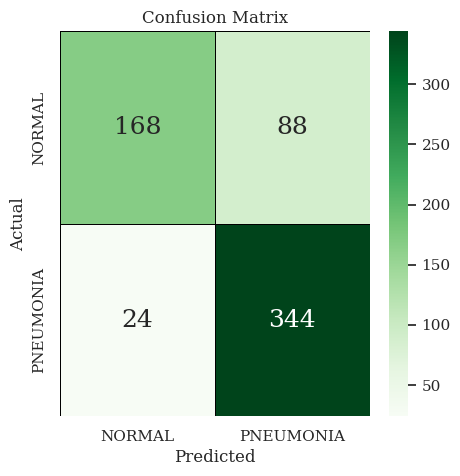

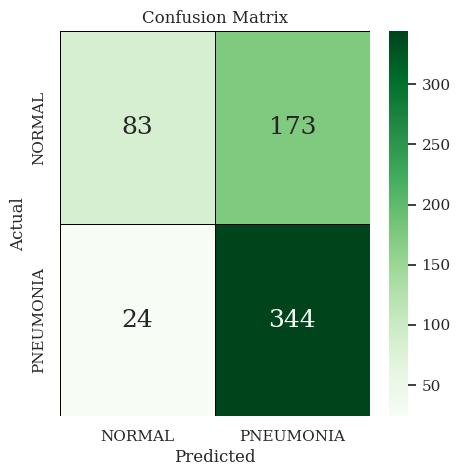

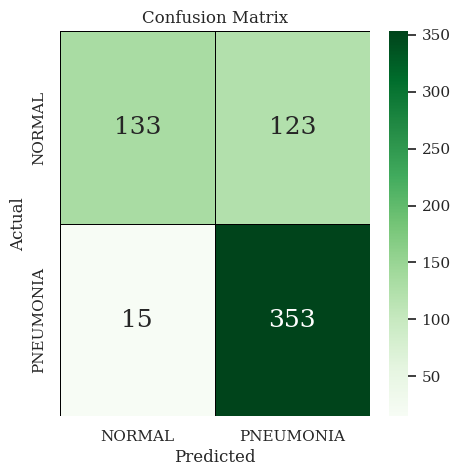

In [ ]:
confusion_m(Softmax_predictions,test_labels,color = 'Greens')
confusion_m(SVM_predictions,test_labels,color = 'Greens')
confusion_m(RF_predictions,test_labels,color = 'Greens')
confusion_m(KNN_predictions,test_labels,color = 'Greens')
confusion_m(adaboost_predictions,test_labels,color = 'Greens')

####Swin and its classifiers

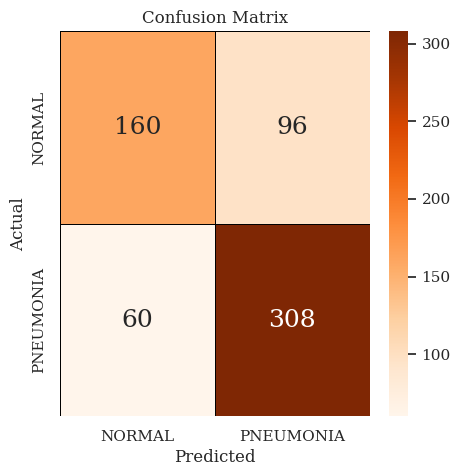

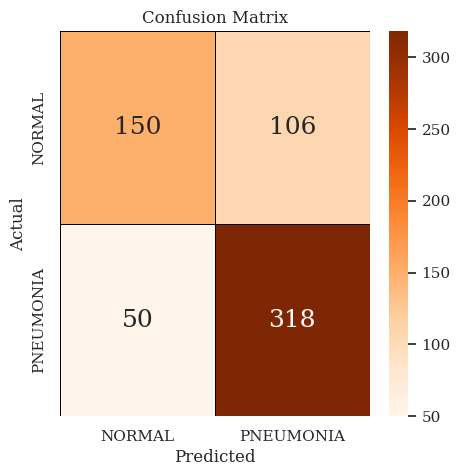

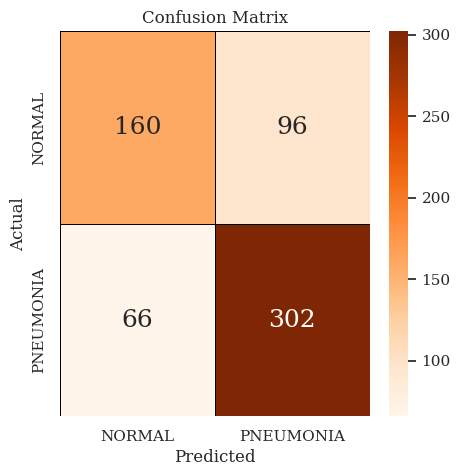

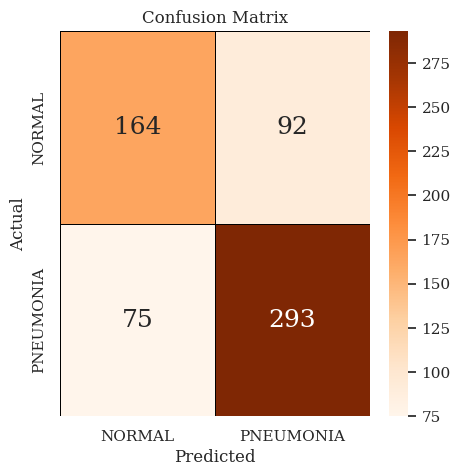

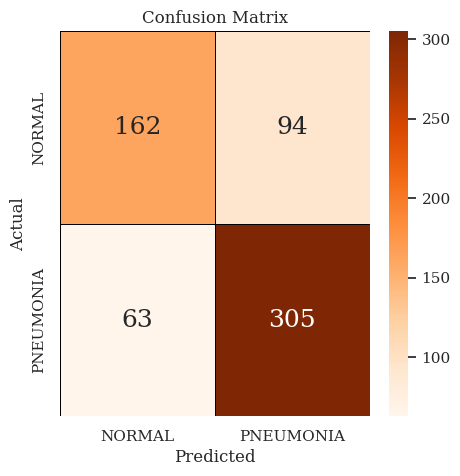

In [ ]:
confusion_m(Swin_Softmax_predictions,test_labels,color = 'Oranges')
confusion_m(Swin_SVM_predictions,test_labels,color = 'Oranges')
confusion_m(Swin_RF_predictions,test_labels,color = 'Oranges')
confusion_m(Swin_KNN_predictions,test_labels,color = 'Oranges')
confusion_m(Swin_adaboost_predictions,test_labels,color = 'Oranges')